In [1]:
import networkx as nx
import osmnx as ox

ox.__version__

'1.9.4'

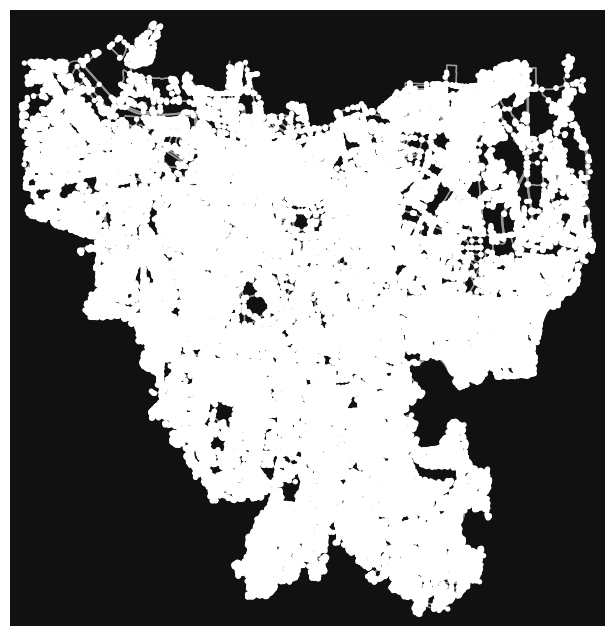

In [2]:
import os

location = "Jakarta"
cache_file = f"{location}_drive.graphml"

# Check if the cache file exists
if os.path.exists(cache_file):
    # Load the graph from the cache file
    G = ox.load_graphml(cache_file)
else:
    # Download the graph and save it to the cache file
    G = ox.graph_from_place(location, network_type="drive")
    ox.save_graphml(G, cache_file)

fig, ax = ox.plot_graph(G)

In [3]:
trip_times = [15, 30, 45, 60, 120]  # in minutes
default_travel_speed = 15

In [4]:
# Get the center node using global coordinates
center_node = ox.distance.nearest_nodes(G, X=106.849833, Y=-6.255770)
center_coords = G.nodes[center_node]['x'], G.nodes[center_node]['y']
G = ox.project_graph(G)

In [5]:
def kmh_to_mpm(kmh):
    return kmh * 1000 / 60

# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in G.edges(data=True, keys=True):
    if False and "maxspeed" in data and any(char.isdigit() for char in str(data["maxspeed"])):
        try:
            if isinstance(data["maxspeed"], str):
                if ',' in data["maxspeed"]:
                    speed = float(min(map(float, data["maxspeed"].split(','))))
                elif data["maxspeed"].isdigit():
                    speed = float(data["maxspeed"])
            elif isinstance(data["maxspeed"], list):
                speed = float(min(int(x) for x in data["maxspeed"] if x.isdigit()))
            else:
                speed = default_travel_speed
        except:
            print(data)
            raise
    else:
        # Default speeds based on highway type
        highway_speeds = {
            "motorway": 60,
            "trunk": 15,
            "primary": 10,
            "secondary": 10,
            "tertiary": 10,
            "residential": 10,
            "living_street": 4,
            "service": 5,
            "unclassified": 5
        }
        highway_type = data.get("highway", "")
        if isinstance(highway_type, list):
            highway_type = highway_type[0] if highway_type else ""
        speed = highway_speeds.get(highway_type, default_travel_speed)
    
    meters_per_minute = kmh_to_mpm(speed)
    data["time"] = data["length"] / meters_per_minute

In [6]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0)

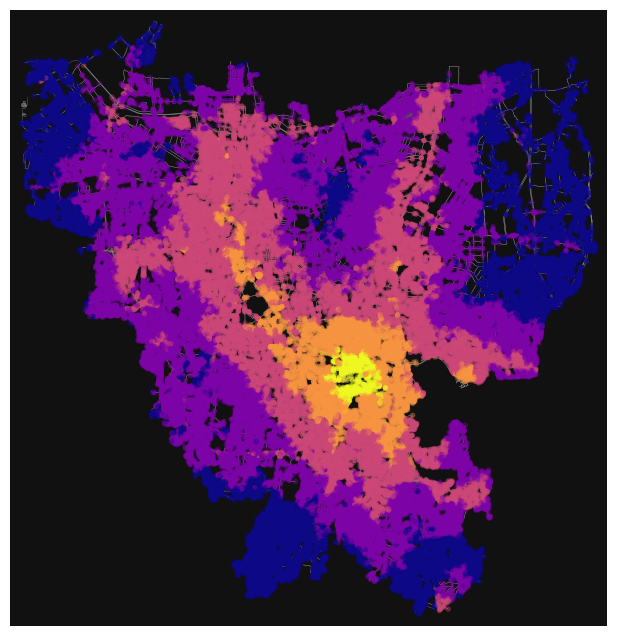

In [12]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.4,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [8]:
from shapely.geometry import Point
import geopandas as gpd

isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

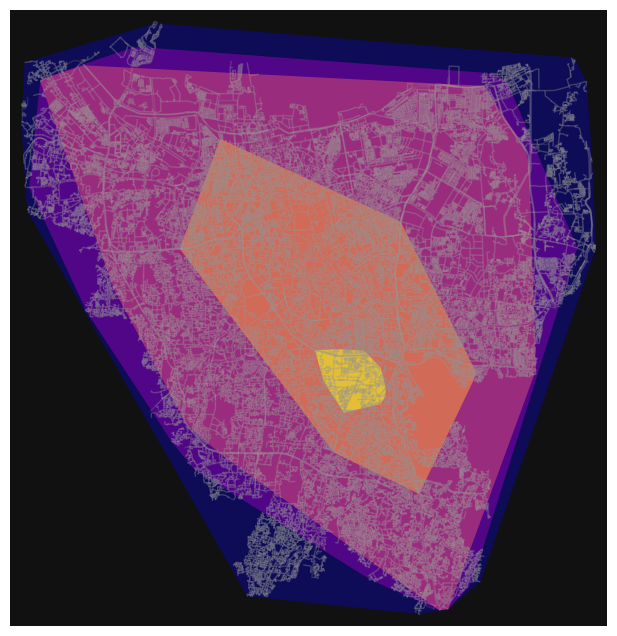

In [9]:
import matplotlib.pyplot as plt

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)

# Plot the center node as a red point
ax.scatter(center_coords[0], center_coords[1], c='red', s=50, zorder=5)

# Plot the center node as a red point
ax.scatter(center_coords[0], center_coords[1], c='red', s=50, zorder=5)

# Add a text label for the coordinates
ax.annotate(f'Origin point', 
            xy=(center_coords[0], center_coords[1]), 
            xytext=(10, 10), 
            textcoords='offset points', 
            ha='left', 
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            fontsize=8)
plt.show()

In [10]:
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon, MultiPolygon

def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            if isinstance(new_iso, MultiPolygon):
                # If it's a MultiPolygon, we'll use the exterior of the largest polygon
                largest_polygon = max(new_iso.geoms, key=lambda p: p.area)
                new_iso = Polygon(largest_polygon.exterior)
            elif isinstance(new_iso, Polygon):
                new_iso = Polygon(new_iso.exterior)
            # If it's neither Polygon nor MultiPolygon, we'll leave it as is
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

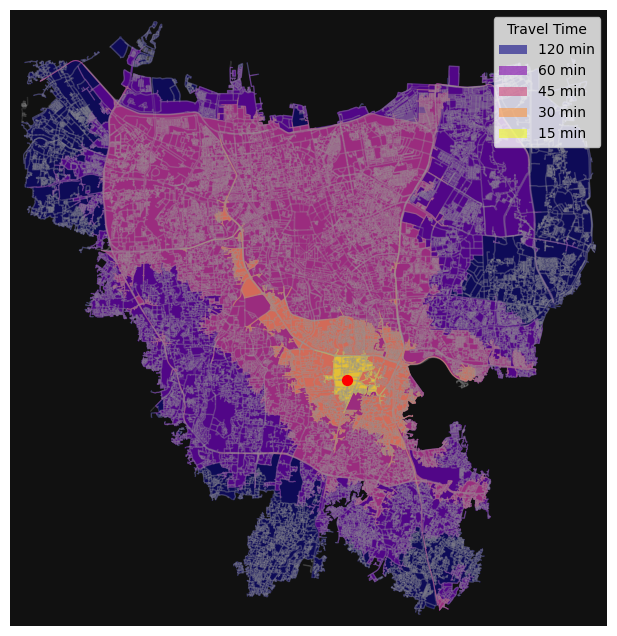

In [11]:

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)

# add center node
center_node_coords = G.nodes[center_node]
ax.scatter(center_node_coords['x'], center_node_coords['y'], c='red', s=50, zorder=5)

# add labels for each travel time
# Create a legend instead of annotations
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color, ec="none", alpha=0.6) 
                   for color in iso_colors]
legend_labels = [f"{time} min" for time in sorted(trip_times, reverse=True)]
ax.legend(legend_elements, legend_labels, loc="upper right", title="Travel Time")

plt.show()